# Predicción para concer si una familia compra o alquila una casa según algunas condiciones socioeconómicas, usando un modelo clasificador Gaussian Naive Bayes

## Librerías

Usaremos las librerias usuales para visualizar la información que tenemos y poder implementar el código

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest

In [2]:
##Importando datos desde la misma ruta donde esta el programa

dataframe = pd.read_csv(r"comprar_alquilar.csv")
dataframe.head()


,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1


Las columnas se tienen son:

- *ingresos*: los ingresos de la familia mensual
- *gastos comunes*: pagos de luz, agua, gas, etc mensual
- *pago coche*: si se está pagando cuota por uno o más coches, y los gastos en combustible, etc al mes.
- *gastos_otros*: compra en supermercado y lo necesario para vivir al mes
- *ahorros*: suma de ahorros dispuestos a usar para la compra de la casa.
- *vivienda*: precio de la vivienda que quiere comprar esa familia
- *estado civil*:
  
  0. soltero
  1. casados
  2. divorciados
  
  
- *hijos*: cantidad de hijos menores y que no trabajan.
- *trabajo*:
  
  0. sin empleo 
  1. autónomo (freelance)
  2. empleado
  3. empresario
  4. pareja: autónomos
  5. pareja: empleados
  6. pareja: autónomo y asalariado
  7. pareja:empresario y autónomo
  8. pareja: empresarios los dos o empresario y empleado
  
  
- comprar: (esta será nuestra columna de salida)
  
  0. No comprar 
  1. Comprar 

### Algunos supuestos para el problema formulado:

- Está pensado en Euros pero podría ser cualquier otra moneda
- No tiene en cuenta ubicación geográfica, cuando sabemos que dependerá mucho los precios de los inmuebles de distintas zonas
- Se supone una hipoteca fija a 30 años con interés de mercado «bajo».

In [ ]:
print(dataframe.groupby('comprar').size())
dataframe.shape

comprar
0    135
1     67
dtype: int64


(202, 10)

Se tienen 135 que prefieren alquilar mientras solo 67 prefieren comprar

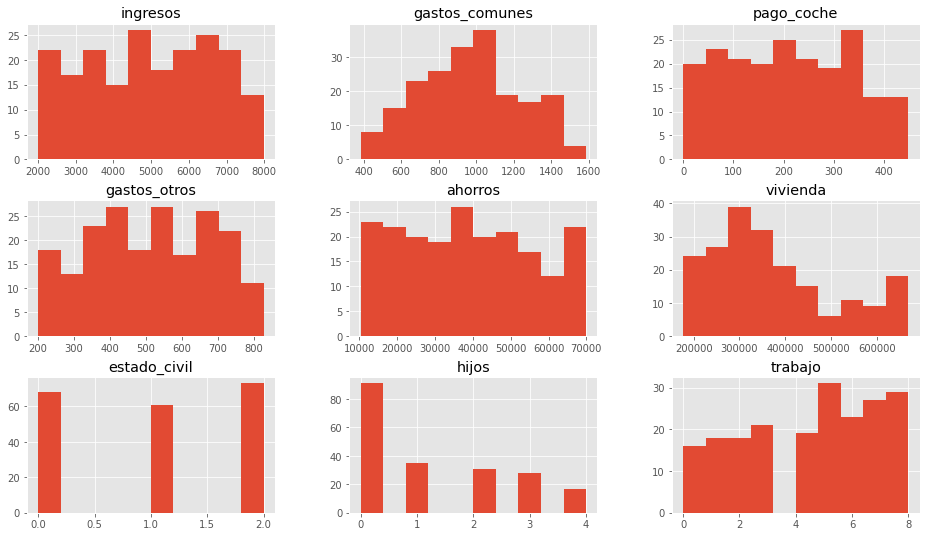

In [6]:
dataframe.drop(['comprar'], axis=1).hist()
plt.show()

Se puede observar que los datos no se distribuyen exactamente normales... Sin embargo, hay que tener en cuenta para ejecutar este algoritmo de '*Gaussian Naive Bayes Classificator*' las siguentes suposiciones:


 - Gausiana -> Asumimos variables con distribución normal, para poder calcular la probabilidad P(B|A) usando la función de densidad de probabilidad normal
 - Ingenua -> Asumimos que las variables no están correlacionadas entre sí, cosa que no siempre es cierto


Se puede observar que los datos aproximadamente normales son hijos e ingresos


Procesando algunas de estas columnas, se pueden agrupar los gastos. También se puede crear una columna llamada "financiar" que será la resta del precio de la vivienda con los ahorros de la familia.

In [7]:
dataframe['gastos']=(dataframe['gastos_comunes']+dataframe['gastos_otros']+dataframe['pago_coche'])
dataframe['financiar']=dataframe['vivienda']-dataframe['ahorros']
dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1).head(10)

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
0,6000,50000,400000,0,2,2,1,1600,350000
1,6745,43240,636897,1,3,6,0,1496,593657
2,6455,57463,321779,2,1,8,1,1926,264316
3,7098,54506,660933,0,0,3,0,1547,606427
4,6167,41512,348932,0,0,3,1,1606,307420
5,5692,50875,360863,1,4,5,1,1247,309988
6,6830,46761,429812,1,1,5,1,1952,383051
7,6470,57439,606291,0,0,1,0,1856,548852
8,6251,50503,291010,0,0,3,1,2030,240507
9,6987,40611,324098,2,1,7,1,1755,283487


Ahora usando el *describe()* de pandas se puede comprobar si nuestros datos se comportan como se espera

In [8]:
reduced = dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1)
reduced.describe()

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,4958.995050,38749.668317,373349.638614,1.024752,1.232673,4.490099,0.331683,1698.752475,334599.970297
std,1682.862556,17365.231870,136371.525622,0.837184,1.367833,2.535794,0.471988,324.838005,126607.099497
min,2008.000000,10319.000000,176553.000000,0.000000,0.000000,0.000000,0.000000,1007.000000,154716.000000
25%,3513.750000,24964.250000,274810.000000,0.000000,0.000000,2.000000,0.000000,1430.500000,240410.250000
50%,4947.500000,38523.000000,340783.500000,1.000000,1.000000,5.000000,0.000000,1669.500000,301177.000000
75%,6374.500000,52150.750000,444482.000000,2.000000,2.000000,7.000000,1.000000,1928.000000,393413.000000
max,7984.000000,69934.000000,669540.000000,2.000000,4.000000,8.000000,1.000000,2543.000000,618621.000000


## Selección de Caracteristicas

En vez de utilizar las 11 columnas de datos de entrada, se procede a utilizar una Clase de SkLearn llamada SelectKBest con la que se seleccionan las 5 mejores características para ser usadas en este problema.

In [9]:
X=dataframe.drop(['comprar'], axis=1)
y=dataframe['comprar']

best=SelectKBest(k=5)
X_new = best.fit_transform(X, y)
selected = best.get_support(indices=True)
print(X.columns[selected])
X_new.shape

Index(['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar'], dtype='object')


(202, 5)

Lo que deja por fuera 6 de las 11 variables que se tenía inicialmente y quedan unicamente con las 5 que "mas aportan" al modelo de clasificación.

Se puede la correlación con el heatmap de correlación de Pearson

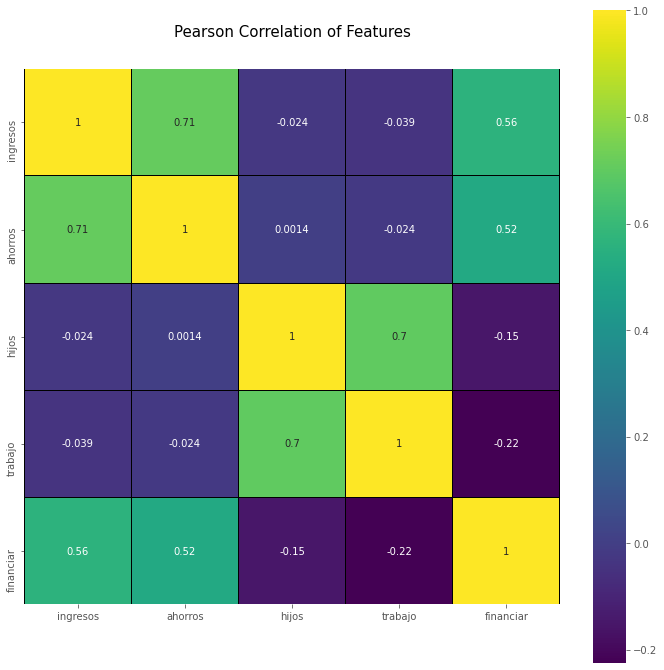

In [10]:
used_features =X.columns[selected]
 
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(dataframe[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='black', annot=True)

En general se ven poco correlacionadas, sin embargo se tienen 2 variables que se correlacion fuertemente con otras (2 valores de 0,7).   Trabajo con hijos y ahorros con ingresos.  

## Creando el modelo de Gaussian Naive Bayes

Primero se deben dividir los datos de entrada entre entrenamiento y test, con 80% para entrenamiento y 20% para testeo.


In [11]:
# Split dataset in training and test datasets
X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state=6) 
y_train =X_train["comprar"]
y_test = X_test["comprar"]

# Crear el modelo y ajustar los datos para evaluar la precisión sobre entranmiento y testeo.

In [12]:
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train[used_features].values,
    y_train
)
y_pred = gnb.predict(X_test[used_features])
 
print('Accuracy in training set: {:.2f}'
     .format(gnb.score(X_train[used_features], y_train)))
print('Accuracy in test set: {:.2f}'
     .format(gnb.score(X_test[used_features], y_test)))

Accuracy in training set: 0.87
Accuracy in test set: 0.90


87% en el conjunto de entrenamiento

90% en el conjunto de test

## Probando con datos desconocidos por el modelo

A continuacion se hacen 3 predicciones para probar el modelo:
- Una familia sin hijos con 2.000€ de ingresos que quiere comprar una casa de 200.000€ y tiene sólo 5.000€ ahorrados.
- Una familia con 2 hijos con ingresos por 6.000€ al mes, 34.000 en ahorros y consultan si comprar una casa de 320.000€.
- Una familia con 2.000€ en ingresos mensuales, 10.000€ ahorrados, 1 solo hijo y quieren una casa de 150.000€


In [13]:
#                 ['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar']
print(gnb.predict([[2000,        5000,     0,       5,         200000],
                   [6000,        34000,    2,       5,         320000],
                   [2000,        10000,    1,       8,         150000]]))

[0 1 0]


# 0 es alquilar y 1 es comprar en este modelo
